In [1]:
import pandas as pd

# Dateipfade
verbrauch_path = "Realisierter_Stromverbrauch_202401010000_202501010000_Viertelstunde.csv"
preise_path = "Gro_handelspreise_202401010000_202501010000_Stunde.csv"
produktion_path = "Realisierte_Erzeugung_202401010000_202501010000_Viertelstunde.csv"

# ggf. dritten Dateipfad ergänzen: dritte_datei_path = "..."

# Einlesen der Viertelstunden-Daten
verbrauch = pd.read_csv(
    verbrauch_path,
    sep=';',
    decimal=',',
    thousands='.',
    parse_dates=['Datum von', 'Datum bis'],
    dayfirst=True
)

# Einlesen der Stundenpreise
produktion = pd.read_csv(
    produktion_path,
    sep=';',
    decimal=',',
    thousands='.',
    parse_dates=['Datum von', 'Datum bis'],
    dayfirst=True
)

# Einlesen der Stundenpreise
preise = pd.read_csv(
    preise_path,
    sep=';',
    decimal=',',
    thousands='.',
    parse_dates=['Datum von', 'Datum bis'],
    dayfirst=True
)

# Beispiel: Zeige die ersten Zeilen
print("Produktion:")
print(produktion.head())


Produktion:
            Datum von           Datum bis  Biomasse [MWh] Originalauflösungen  \
0 2024-01-01 00:00:00 2024-01-01 00:15:00                              981.00   
1 2024-01-01 00:15:00 2024-01-01 00:30:00                              979.75   
2 2024-01-01 00:30:00 2024-01-01 00:45:00                              979.75   
3 2024-01-01 00:45:00 2024-01-01 01:00:00                              980.25   
4 2024-01-01 01:00:00 2024-01-01 01:15:00                              974.50   

   Wasserkraft [MWh] Originalauflösungen  \
0                                 491.00   
1                                 495.50   
2                                 491.75   
3                                 490.25   
4                                 490.50   

   Wind Offshore [MWh] Originalauflösungen  \
0                                  1459.75   
1                                  1437.00   
2                                  1404.50   
3                                  1378.00   
4     

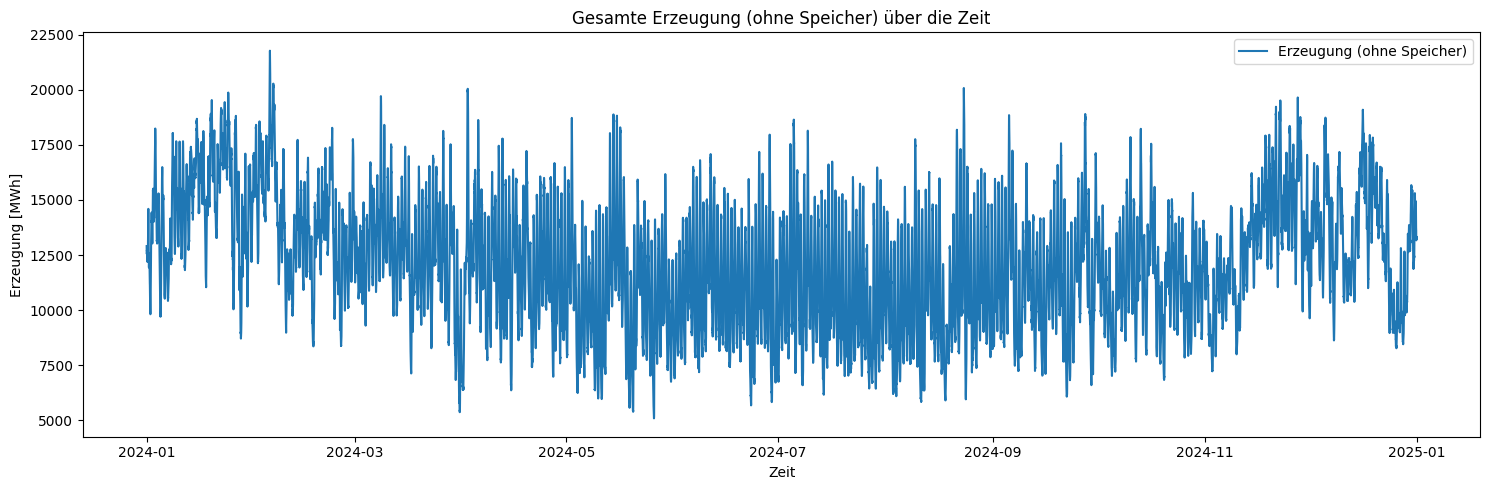

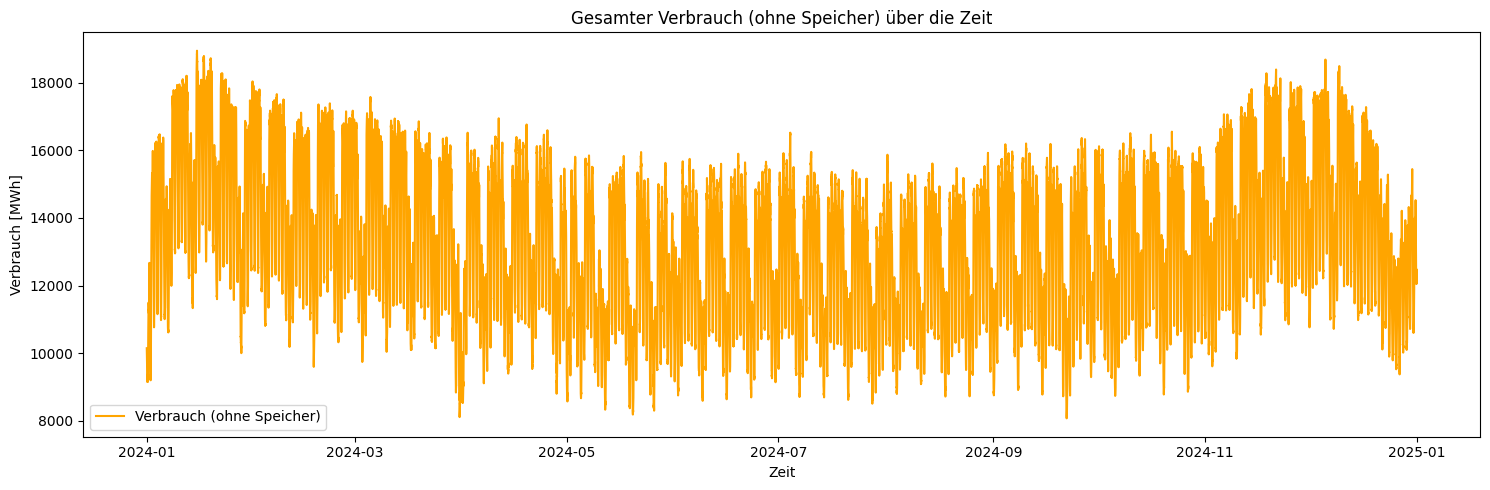

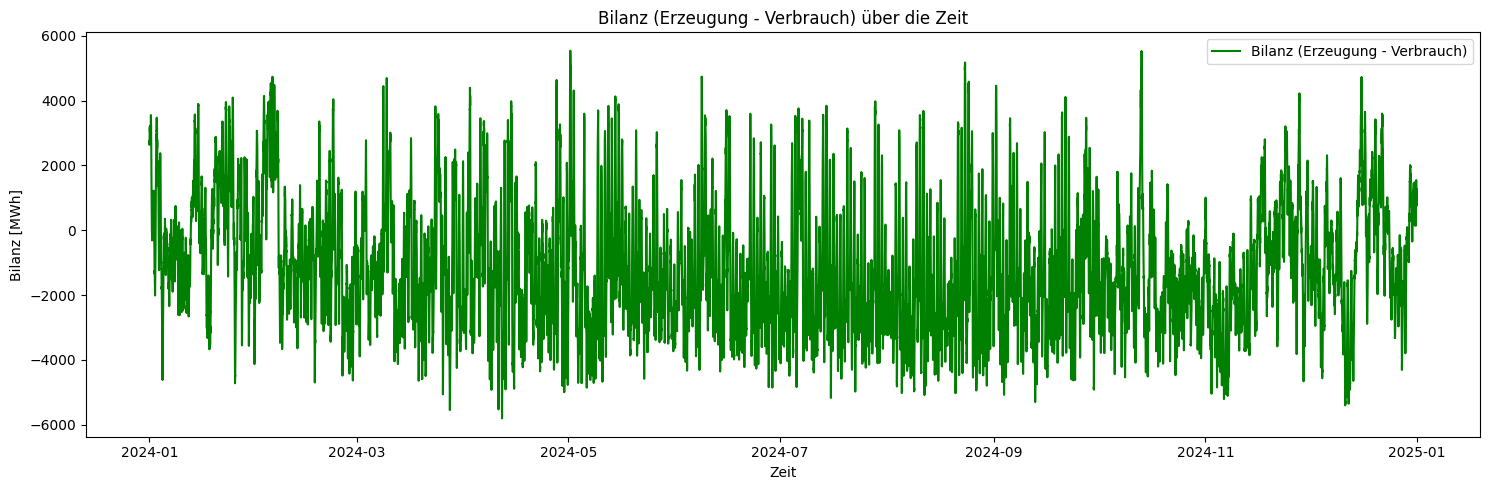

In [2]:
import matplotlib.pyplot as plt

# Liste der Erzeugungsspalten (ohne Pumpspeicher)
erzeugungsspalten = [
    'Biomasse [MWh] Originalauflösungen',
    'Wasserkraft [MWh] Originalauflösungen',
    'Wind Offshore [MWh] Originalauflösungen',
    'Wind Onshore [MWh] Originalauflösungen',
    'Photovoltaik [MWh] Originalauflösungen',
    'Sonstige Erneuerbare [MWh] Originalauflösungen',
    'Kernenergie [MWh] Originalauflösungen',
    'Braunkohle [MWh] Originalauflösungen',
    'Steinkohle [MWh] Originalauflösungen',
    'Erdgas [MWh] Originalauflösungen',
    'Sonstige Konventionelle [MWh] Originalauflösungen'
]

erneuerbare_Produktion_Spalten = [
    'Biomasse [MWh] Originalauflösungen',
    'Wasserkraft [MWh] Originalauflösungen',
    'Wind Offshore [MWh] Originalauflösungen',
    'Wind Onshore [MWh] Originalauflösungen',
    'Photovoltaik [MWh] Originalauflösungen',
    'Sonstige Erneuerbare [MWh] Originalauflösungen'
]

# Spalten explizit in float umwandeln
for spalte in erzeugungsspalten:
    produktion[spalte] = produktion[spalte].astype(str)  # erzwinge String
    # produktion[spalte] = produktion[spalte].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    produktion[spalte] = pd.to_numeric(produktion[spalte], errors='coerce')  # zurück zu float

# Gesamte Erzeugung (ohne Pumpspeicher) berechnen
erzeugung_ohne_speicher = produktion[erzeugungsspalten].sum(axis=1)

verbrauch['Netzlast [MWh] Originalauflösungen'] = verbrauch['Netzlast [MWh] Originalauflösungen'].astype(str)
# verbrauch['Netzlast [MWh] Originalauflösungen'] = verbrauch['Netzlast [MWh] Originalauflösungen'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
verbrauch['Netzlast [MWh] Originalauflösungen'] = pd.to_numeric(verbrauch['Netzlast [MWh] Originalauflösungen'], errors='coerce')

# Plot 1: Gesamte Erzeugung gegen Zeit (ohne Speicher)
plt.figure(figsize=(15,5))
plt.plot(produktion['Datum von'], erzeugung_ohne_speicher, label='Erzeugung (ohne Speicher)')
plt.title('Gesamte Erzeugung (ohne Speicher) über die Zeit')
plt.xlabel('Zeit')
plt.ylabel('Erzeugung [MWh]')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Gesamter Verbrauch gegen Zeit (ohne Speicher)
plt.figure(figsize=(15,5))
plt.plot(verbrauch['Datum von'], verbrauch['Netzlast [MWh] Originalauflösungen'], label='Verbrauch (ohne Speicher)', color='orange')
plt.title('Gesamter Verbrauch (ohne Speicher) über die Zeit')
plt.xlabel('Zeit')
plt.ylabel('Verbrauch [MWh]')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Bilanz (Erzeugung - Verbrauch) gegen Zeit
bilanz = erzeugung_ohne_speicher.values - verbrauch['Netzlast [MWh] Originalauflösungen'].values
plt.figure(figsize=(15,5))
plt.plot(produktion['Datum von'], bilanz, label='Bilanz (Erzeugung - Verbrauch)', color='green')
plt.title('Bilanz (Erzeugung - Verbrauch) über die Zeit')
plt.xlabel('Zeit')
plt.ylabel('Bilanz [MWh]')
plt.legend()
plt.tight_layout()
plt.show()

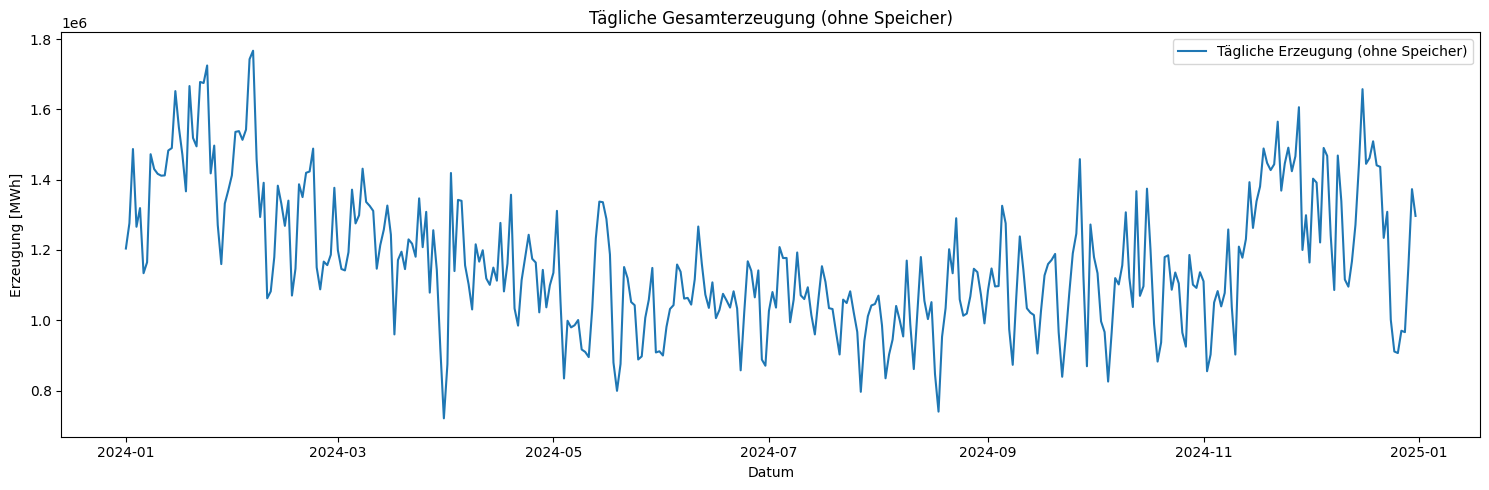

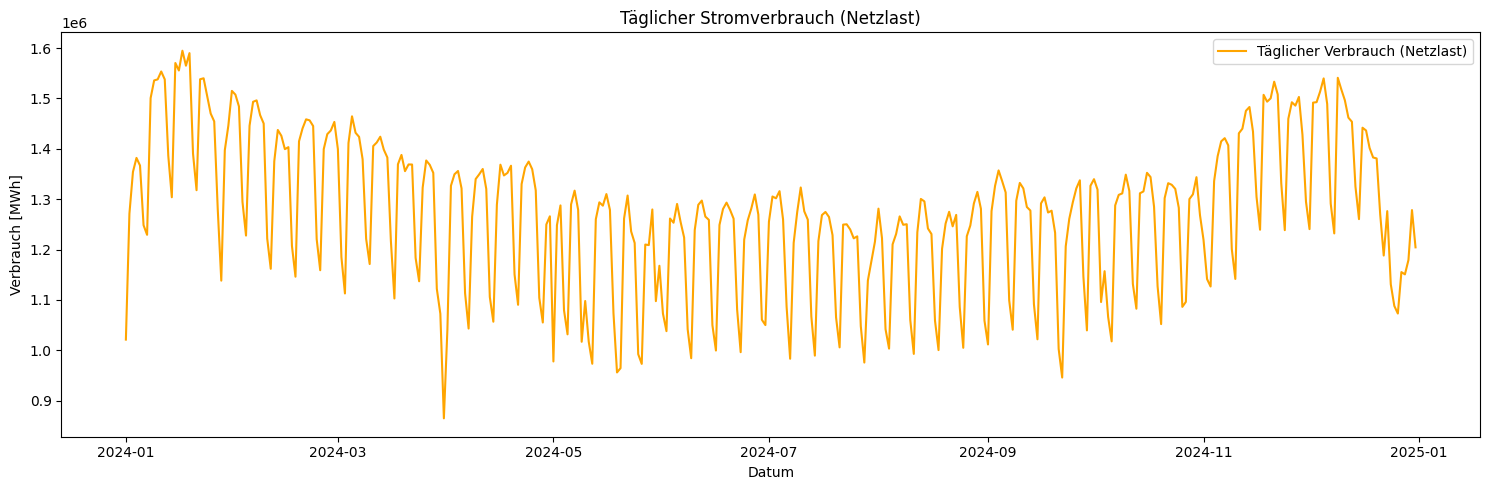

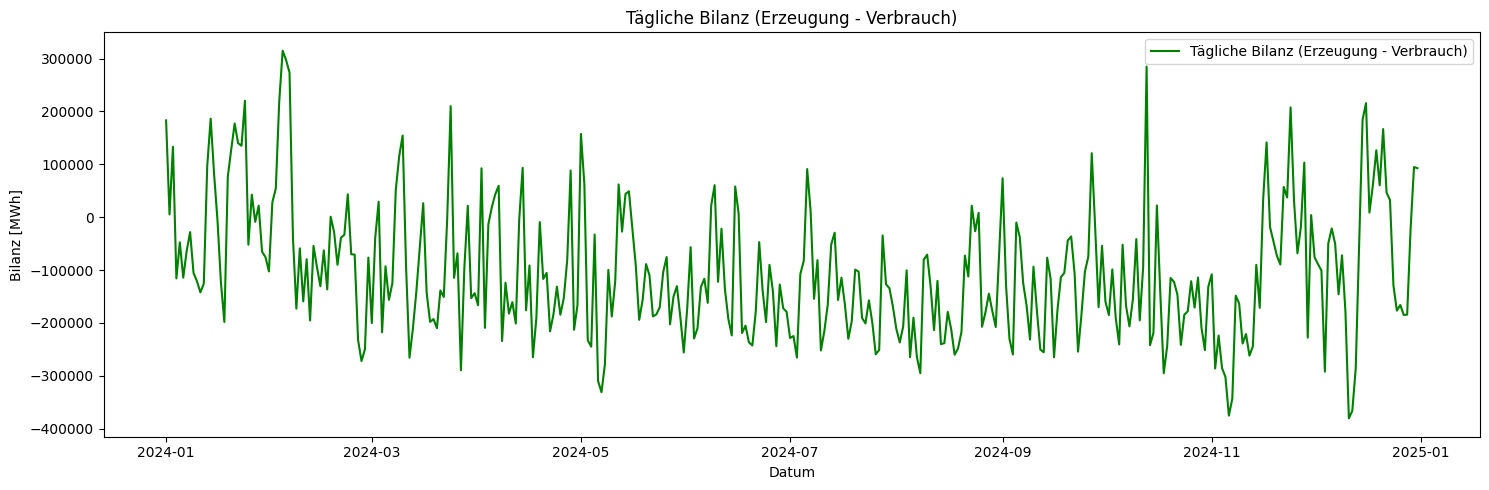

In [3]:
# Neues Tagesdatum in beiden DataFrames
produktion['Tag'] = produktion['Datum von'].dt.floor('D')
verbrauch['Tag'] = verbrauch['Datum von'].dt.floor('D')

# Tägliche Erzeugung berechnen (ohne Speicher)
tägliche_erzeugung = produktion.groupby('Tag')[erzeugungsspalten].sum().sum(axis=1)

# Täglicher Verbrauch (Netzlast)
täglicher_verbrauch = verbrauch.groupby('Tag')['Netzlast [MWh] Originalauflösungen'].sum()

# Bilanz: Erzeugung - Verbrauch
tägliche_bilanz = tägliche_erzeugung - täglicher_verbrauch

# Plot 1: Tages-Erzeugung
plt.figure(figsize=(15, 5))
plt.plot(tägliche_erzeugung.index, tägliche_erzeugung.values, label='Tägliche Erzeugung (ohne Speicher)')
plt.title('Tägliche Gesamterzeugung (ohne Speicher)')
plt.xlabel('Datum')
plt.ylabel('Erzeugung [MWh]')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Tages-Verbrauch
plt.figure(figsize=(15, 5))
plt.plot(täglicher_verbrauch.index, täglicher_verbrauch.values, label='Täglicher Verbrauch (Netzlast)', color='orange')
plt.title('Täglicher Stromverbrauch (Netzlast)')
plt.xlabel('Datum')
plt.ylabel('Verbrauch [MWh]')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Tagesbilanz
plt.figure(figsize=(15, 5))
plt.plot(tägliche_bilanz.index, tägliche_bilanz.values, label='Tägliche Bilanz (Erzeugung - Verbrauch)', color='green')
plt.title('Tägliche Bilanz (Erzeugung - Verbrauch)')
plt.xlabel('Datum')
plt.ylabel('Bilanz [MWh]')
plt.legend()
plt.tight_layout()
plt.show()


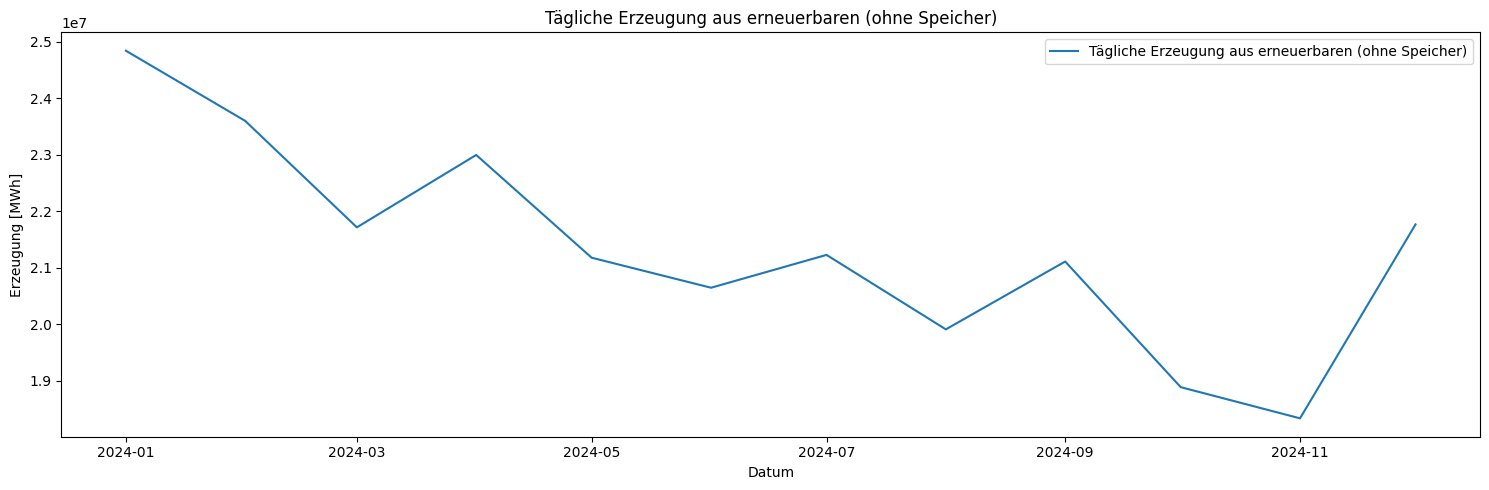

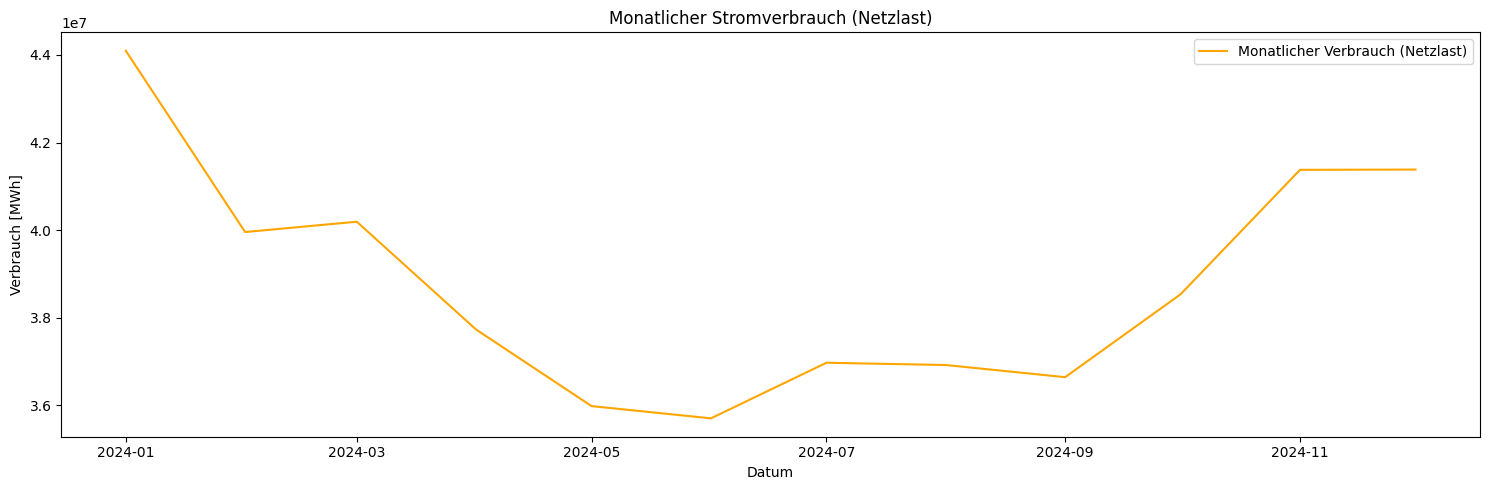

In [11]:
# Neues Monatsdatum in beiden DataFrames
produktion['Monat'] = produktion['Datum von'].dt.to_period('M').dt.to_timestamp()
verbrauch['Monat'] = verbrauch['Datum von'].dt.to_period('M').dt.to_timestamp()

# erneuerbare_Produktion = produktion[erneuerbare_Produktion_Spalten].sum(axis=1

# Monatliche Erzeugung berechnen (ohne Speicher)
tägliche_erzeugung = produktion.groupby('Monat')[erneuerbare_Produktion_Spalten].sum().sum(axis=1)

täglicher_verbrauch = verbrauch.groupby('Monat')['Netzlast [MWh] Originalauflösungen'].sum()

# Plot 1: Tages-Erzeugung
plt.figure(figsize=(15, 5))
plt.plot(tägliche_erzeugung.index, tägliche_erzeugung.values, label='Tägliche Erzeugung aus erneuerbaren (ohne Speicher)')
plt.title('Tägliche Erzeugung aus erneuerbaren (ohne Speicher)')
plt.xlabel('Datum')
plt.ylabel('Erzeugung [MWh]')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Tages-Verbrauch
plt.figure(figsize=(15, 5))
plt.plot(täglicher_verbrauch.index, täglicher_verbrauch.values, label='Monatlicher Verbrauch (Netzlast)', color='orange')
plt.title('Monatlicher Stromverbrauch (Netzlast)')
plt.xlabel('Datum')
plt.ylabel('Verbrauch [MWh]')
plt.legend()
plt.tight_layout()
plt.show()